In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn import decomposition
import sys
import torch

sys.path.append(os.path.join(os.getenv("HOME"), "RNN_Manifold/"))
import decode_1d, geometry_util

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


First, load the data. In this notebook I am using data from Mouse 28-140313 (same as nature paper fig.2). The only preprocessing that has been applied is a smoothing of spikes to produce rates.

In [3]:
data_dir = "/home/trevor/manifold_test_data/experimental_ring_data"
data = np.squeeze(np.load(os.path.join(data_dir, "encoded_points.npy")))
angles = np.squeeze(np.load(os.path.join(data_dir, "true_phases.npy")))

Linear dimensionality reduction helps to mitigate the effects of bottlenecking in the model

In [4]:
pca_instance = decomposition.PCA(n_components=10)
proj_data = pca_instance.fit_transform(np.sqrt(data))
normed_rates = proj_data/np.mean(np.abs(proj_data))

Fit the manifold

In [5]:
decoder_hidden_size = 1000
encoder_hidden_size = int(1.5 * decoder_hidden_size)
decoder_n_hidden = 2
encoder_n_hidden = decoder_n_hidden

In [7]:
encoder, decoder, _ = decode_1d.train(data=normed_rates, n_circular_dimensions=1, n_linear_dimensions=0, device=device,
                                                   n_training_iterations=500, decoder_weight=10, order_red_weight=0.1, batch_size=50, encoder_hidden_dim=encoder_hidden_size, encoder_n_hidden=encoder_n_hidden, decoder_hidden_dim=decoder_hidden_size, decoder_n_hidden=decoder_n_hidden)


/home/trevor/brainvenv/lib/python3.8/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


iteration: 0, decoding loss: 2.223644971847534, distance cost: 0.11309891194105148, order reduction: 0.0013971584849059582
iteration: 1, decoding loss: 1.8719565868377686, distance cost: 0.3789716958999634, order reduction: 0.003257271135225892
iteration: 4, decoding loss: 1.3896797895431519, distance cost: 0.3123031258583069, order reduction: 0.004562675952911377
iteration: 6, decoding loss: 1.212175726890564, distance cost: 0.19033372402191162, order reduction: 0.0020269742235541344
iteration: 9, decoding loss: 1.1493480205535889, distance cost: 0.08155207335948944, order reduction: 0.0022303962614387274
iteration: 11, decoding loss: 1.0767704248428345, distance cost: 0.04344615340232849, order reduction: 0.0019680552650243044
iteration: 14, decoding loss: 1.0343440771102905, distance cost: 0.3361988067626953, order reduction: 0.0023853532038629055
iteration: 15, decoding loss: 0.8871088624000549, distance cost: 0.15935960412025452, order reduction: 0.002465857658535242
iteration: 16

If it doesn't get stuck we should end up with a decoding loss of around 0.2 for this dataset. We can do some random projections of the results

In [8]:
n_projections = 6
embed_dim = np.shape(normed_rates)[1]
random_projections = np.random.normal(0, 1, (n_projections, 2, embed_dim))
col_norm = np.einsum("ijk, ijk -> ik", random_projections, random_projections)
normed_proj = np.einsum("ijk, ik -> ijk", random_projections, 1/np.sqrt(col_norm))
projected_data = np.einsum("bk, ijk -> bij", normed_rates, normed_proj)

In [9]:
test_angles = np.linspace(start=0, stop=2 * np.pi, num=1000)
with torch.no_grad():
    test_embedding = encoder(torch.tensor(np.expand_dims(test_angles, -1), dtype=torch.get_default_dtype()).to(device))
test_embedding = test_embedding.cpu().numpy()
projected_test_embedding = np.einsum("bk, ijk -> bij", test_embedding, normed_proj)


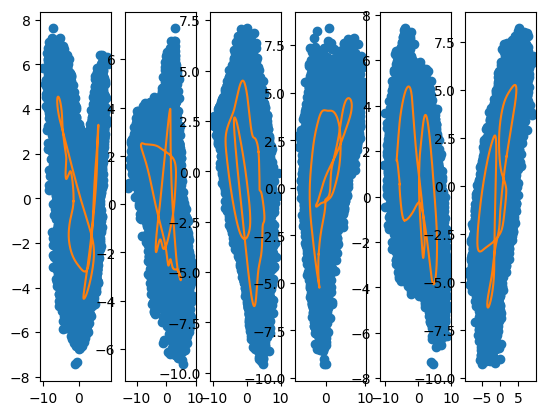

In [10]:
data_plot_density = 1
fig, axs = plt.subplots(ncols=n_projections)
for i in range(n_projections):
    axs[i].scatter(projected_data[::data_plot_density, i, 0], projected_data[::data_plot_density, i, 1], color="C0")
    axs[i].plot(projected_test_embedding[:, i, 0], projected_test_embedding[:, i, 1], color="C1")


These generally aren't that useful: if they were, PCA alone would probably be enough to reveal the ring structure.

Now compare to ground-truth head direction information

In [12]:
with torch.no_grad():
    decoded_angles = decoder(torch.tensor(normed_rates, dtype=torch.get_default_dtype()).to(device))

predicted_phases = torch.squeeze(decoded_angles).cpu().numpy()


In [14]:
def compare_to_ground_truth(predicted_phases, ground_truth_phases, plot_ax):
    refd_test_phases = geometry_util.reference_periodic_phases(predicted_phases)
    refd_true_phases = geometry_util.reference_periodic_phases(ground_truth_phases)
    line = np.arange(start=-np.pi, stop=np.pi, step=0.01)
    plot_ax.scatter(refd_true_phases, refd_test_phases)
    plot_ax.plot(line, line, color="black", linestyle="--", label="y=x")
    plot_ax.set_xlabel("True Phase")
    plot_ax.set_ylabel("Found Phase")
    return refd_test_phases, refd_true_phases


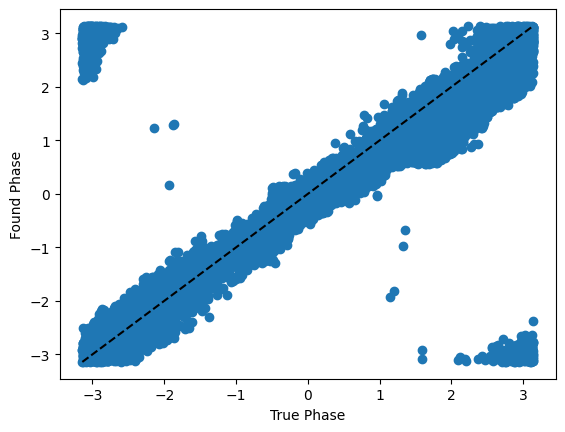

In [15]:
fig, axs = plt.subplots()
refd_pred, refd_data = compare_to_ground_truth(predicted_phases, angles, axs)


If the decoding worked, the data should be randomly and evenly distributed around the line y=x (or y=-x if the sign convention is detected incorrectly). If this is the case, the residual error is due to noise. Alternatively, in histogram form,

Text(0, 0.5, 'Counts')

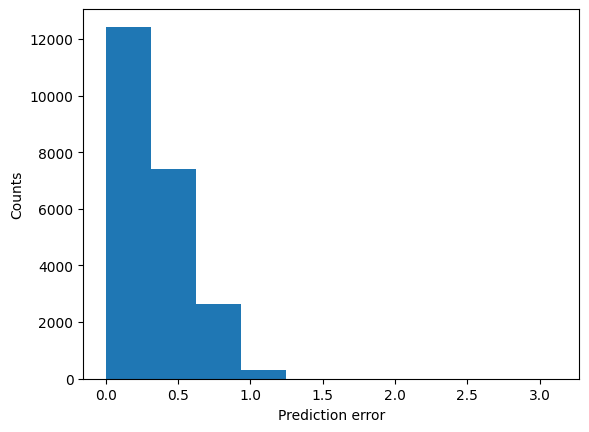

In [16]:
with torch.no_grad():
    errors, _, _ = geometry_util.minimum_periodic_distance(torch.Tensor(np.expand_dims(refd_pred, -1)), torch.Tensor(np.expand_dims(refd_data, -1)))
fig, axs = plt.subplots()
axs.hist(errors)
axs.set_xlabel("Prediction error")
axs.set_ylabel("Counts")
